# Applying dimensionality reduction to 820'676 image features

In [2]:
from __future__ import division, print_function

import os
# coding=utf-8
import sys
import time
from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables
from IPython.display import HTML, display
from tqdm import tqdm

np.set_printoptions(threshold=np.nan) # prints the whole nparray no matter the shape of it

## Load existing image features with pytables

In [20]:
hdf5_file_original_1 = tables.open_file('models/vgg16_bottleneck_features.hdf5', mode='r')
features_original_1 = hdf5_file_original_1.root.img_features # Sparse data, mostly zeros
images_original_1 = hdf5_file_original_1.root.img_paths

hdf5_file_original_2 = tables.open_file('models/vgg16_bottleneck_features_02.hdf5', mode='r')
features_original_2 = hdf5_file_original_2.root.img_features # Sparse data, mostly zeros
images_original_2 = hdf5_file_original_2.root.img_paths

#### Path for the new, third table containg merged image features

In [2]:
hdf5_path_pca = 'models/vgg16_bottleneck_features_PCA.hdf5'

#### Creating a new tables file which contains merged image paths and merged image features from both preexisting files

In [32]:
hdf5_file_pca = tables.open_file(hdf5_path_pca, mode='w')

images_original_3 = hdf5_file_pca.create_array(hdf5_file_pca.root,
                                               'img_paths', atom=images_original_1.atom,
                                               shape=(images_original_1.nrows + images_original_2.nrows,))

#### Combining image paths from first file and second file

In [33]:
images_original_3[:images_original_1.nrows] = images_original_1[:]
images_original_3[images_original_1.nrows:] = images_original_2[:]

#### Flushing pending data to disk

In [34]:
images_original_3.flush()

### features_pca will contain all raw image features

In [44]:
data_shape = (0, 4096)
img_dtype = tables.Float32Atom()

features_pca = hdf5_file_pca.create_earray(hdf5_file_pca.root, 'img_features', img_dtype, shape=data_shape)

In [45]:
features_pca.append(features_original_1.read())
features_pca.flush()

ft_2_np = features_original_2.read()
features_original_1.append(ft_2_np)
features_pca.flush()

In [50]:
hdf5_file_pca.close()

##### Loading merged data

In [4]:
hdf5_file_pca = tables.open_file(hdf5_path_pca, mode='r')

In [5]:
features_pca = hdf5_file_pca.root.img_features
images_pca = hdf5_file_pca.root.img_paths

In [6]:
features_pca.shape[0]

820676

## Principal component analysis

The image features take up **12.52 GB** (820'676*4'096*32)/(8*1'024*1'024*1'024) which is simply to big to load it completely into ram. Instead, sklearn provides us with an altered pca implementation enabling us to calculate the eigenvalues batchwise.

In [10]:
from sklearn.decomposition import IncrementalPCA

n = features_pca.shape[0] # how many rows we have in the dataset
chunk_size = 82000 # how many rows we feed to IPCA at a time, the divisor of n
ipca = IncrementalPCA(n_components=512, batch_size=41000)

for i in tqdm(range(0, n//chunk_size)):
    ipca.partial_fit(features_pca[i*chunk_size : (i+1)*chunk_size])

100%|██████████| 10/10 [44:02<00:00, 269.60s/it]


In [16]:
ipca.partial_fit(features_pca[820000:]) # 820'000 = chunk_size*(n//chunk_size)

IncrementalPCA(batch_size=41000, copy=True, n_components=512, whiten=False)

Storing the IncrementalPCA(batch_size=41000, copy=True, n_components=512, whiten=False) object on disk:

In [17]:
import pickle

pickle.dump(ipca, open('models/sklearn_ipca_object.p', 'wb'))

Loading it into mem:

In [3]:
import pickle
pickle_in = open("models/sklearn_ipca_object.p","rb")
ipca = pickle.load(pickle_in)

### Creating our final hdf5 file
#### Path for the new, third table containg reduced image features

In [30]:
hdf5_path_ipca = 'models/vgg16_bottleneck_features_IPCA.hdf5'

In [21]:
hdf5_file_ipca = tables.open_file(hdf5_path_ipca, mode='w') # Create new hdf5 file

# Takes up 61.6 MB on disk
hdf5_file_ipca.create_array(hdf5_file_ipca.root, 'img_paths', images_pca.read()) # Create array for image paths

data_shape = (0, 512) # Shape is now 512!
img_dtype = tables.Float32Atom()

# Create enlargeable array for image features
features_ipca = hdf5_file_ipca.create_earray(hdf5_file_ipca.root, 'img_features', img_dtype, shape=data_shape)

In [22]:
# PCA.transform actually returns float64 rather than float32

n = features_pca.shape[0] # how many rows we have in the dataset
chunk_size = 82000 # how many rows we feed to IPCA at a time, the divisor of n

for i in tqdm(range(0, n//chunk_size)):
    features_ipca.append(ipca.transform(features_pca[i*chunk_size : (i+1)*chunk_size]))
    
features_ipca.append(ipca.transform(features_pca[820000:])) # 820'000 = chunk_size*(n//chunk_size)


100%|██████████| 10/10 [02:48<00:00, 17.56s/it]


In [23]:
features_ipca.shape

(820676, 512)

### Flushing and closing our pytable to disk

In [26]:
hdf5_file_ipca.close()

## Preparing image features for nmslib

In [5]:
hdf5_path_ipca = 'models/vgg16_bottleneck_features_IPCA.hdf5'
hdf5_file_ipca = tables.open_file(hdf5_path_ipca, mode='r') # Create new hdf5 file
features_ipca = hdf5_file_ipca.root.img_features
images = hdf5_file_ipca.root.img_paths

In [6]:
import nmslib

# nmslib default params for now

# Number of neighbors
K = 18
# Set index parameters
# These are the most important ones
M = 15
efC = 100
num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
space_name='l2'
efS = 100
query_time_params = {'efSearch': efS}
index_ann = None

In [8]:
def init_ann_index(bin_PATH='models/image_features_pca_nmslib_index.bin'):
    global index_ann
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
    # Re-load the index and re-run queries
    index_ann.loadIndex(bin_PATH)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    index_ann.setQueryTimeParams(query_time_params)

In [9]:
init_ann_index()

Setting query-time parameters {'efSearch': 100}


In [41]:
def create_ann_index(bin_PATH):
    global index_ann
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
    index_ann.addDataPointBatch(features_ipca.read())
    index_ann.createIndex(index_time_params, print_progress=True)
    index_ann.saveIndex(bin_PATH)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    index_ann.setQueryTimeParams(query_time_params)

In [42]:
create_ann_index('models/image_features_pca_nmslib_index.bin')

Setting query-time parameters {'efSearch': 100}


## Testing the new model and the new hnsw index

In [10]:
from IPython.display import display, HTML
from pprint import pprint

import matplotlib.pyplot

from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input as preprocess_input_vgg
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inc
from keras.utils.np_utils import to_categorical
from keras.models import Model, load_model
from keras import metrics

from chefkochParser import food_list_html
import logger

MODEL_PATH = 'models/inceptionv3_4_new_ohne_dpot_2.97270.hdf5'
MODEL_VGG_PATH = 'models/weights.bestVGG16try9.hdf5'
CHEFKOCH_PATH = 'https://www.chefkoch.de/rezepte/'
model_inc = None
feat_extractor = None

Using TensorFlow backend.


Loading JSON


In [11]:
with open('meta/classes_230.txt', 'r') as textfile:
    categories = textfile.read().splitlines()

In [12]:
def load_models(MODEL_PATH):
    global model_inc, feat_extractor
    model_inc = load_model(MODEL_PATH, custom_objects={'top_10_accuracy': top_10_accuracy})
    model_inc._make_predict_function()
    model_vgg = VGG16(weights='imagenet', include_top=True)
    #model_vgg = load_model(MODEL_VGG_PATH)
    feat_extractor = Model(inputs=model_vgg.input, outputs=model_vgg.get_layer("fc2").output)
    img, x = get_image_vgg("meta/kuchen.jpg")
    feat = feat_extractor.predict(x)
    print('Models loaded. Start serving...')
    
chefkoch_rezepte = pd.read_csv('meta/chefkoch.csv', index_col=False)

In [13]:
def top_10_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)

# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image_vgg(path):
    img = image.load_img(path, target_size=feat_extractor.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_vgg(x)
    return img, x
  
def get_image_inc(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_inc(x)
    return img, x
  
def plot_preds(image, probabilities, top_n):
    plt.imshow(image)
    plt.axis('off')
    plt.figure()
    
    order = list(reversed(range(top_n)))
    labels = [categories[x] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    bar_preds = [-np.sort(-probabilities)[i] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    
    plt.barh(order, bar_preds, alpha=0.8, color='g')
    plt.title('the higher, the better', loc='center')
    plt.yticks(order, labels, color='g')
    plt.xlabel('Probability', color='g')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()
    
def plot_distances(distances, idx_closest):    
    order = list(range(len(distances)))[::-1] # just a list from 0 to K-1
    labels = [str(images[i]).split('/')[1] for i in idx_closest]
    
    plt.barh(order, distances, alpha=0.8, color='g')
    plt.title('the lower, the better', loc='center')
    plt.yticks(order, labels, color='g')
    plt.xlabel('L2 distance (euclidean)', color='g')
    plt.tight_layout()
    plt.show()

def show_result_images(final_result):
    rows = 6
    cols = 3
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(12, 12))
    fig.suptitle('Result Images from Query', fontsize=20)
    food_dirs = [food_direction[4] for food_direction in final_result]
    for i in range(rows):
        for j in range(cols):
            food_dir = food_dirs[i*cols + j]
            img = plt.imread('/Users/Muriz/Desktop/Extracting-food-preferences-master/notebooks/input/images/'+food_dir)
            ax[i][j].imshow(img)
            ec = (0, .6, .1)
            fc = (1, 1, 1)
            ax[i][j].text(0, 0, get_corresponding_recipes(final_result).recipe_name[i*cols + j], size=15, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def get_closest_images_nmslib(query_features, num_results=K):
    return index_ann.knnQuery(query_features, k = num_results)
    
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

def get_corresponding_recipes(final_results, chefkoch_rezepte=chefkoch_rezepte):
    chefkoch_rezepte_result = pd.DataFrame()
    for recipe_id_single in final_results:
        chefkoch_rezepte_result = chefkoch_rezepte_result.append(chefkoch_rezepte.query('recipe_id in @recipe_id_single[2]'), ignore_index=True)
    return chefkoch_rezepte_result

In [14]:
load_models(MODEL_PATH)

Models loaded. Start serving...


In [48]:
def weighting_neural_net_inputs(query_features, probabilities):
    """Combine outputs from Inceptionv3 and VGG-16 to a result list.
    
    Argument:
    query_features: query image fingerprint from VGG-16
    probabilities: Inception's category probabilities
    
    Return: final list containing category, inception's confidence,
            recipe id, image index and image path.
    """
    # do a query on image
    idx_closest, distances = get_closest_images_nmslib(query_features)
    
    plot_distances(distances, idx_closest)
    
    # Don't forget to adjust string slicing for second hdf5
    # Labels only from ANN
    predicted_labels = [str(images[i]).split('/')[1] for i in idx_closest]
    
    # Results only from ANN
    predicted_ids = [[str(images[i]).split('-')[1], str(images[i]).split('-')[2].split('.')[0], 
                      images[i].decode("utf-8")] for i in idx_closest]
    
    pred_categories = []

    for i, x in enumerate(np.argsort(-probabilities)[:K]):
        confidence = -np.sort(-probabilities)[i]
        #print(categories[x], confidence)
        pred_categories.append([categories[x], confidence])
      
    predicted_labels_with_weights = []
    for iii in predicted_labels:
        for iiii, ii in enumerate(pred_categories):
            no_result = False
            if ii[0] == iii:
                predicted_labels_with_weights.append([iii, ii[1]])
                break
            if iiii == len(pred_categories)-1:
                predicted_labels_with_weights.append([iii, 0])
          
    predicted_labels_with_meta = [xi+yi for xi, yi in zip(predicted_labels_with_weights, predicted_ids)]
    final_result = sorted(predicted_labels_with_meta, key=lambda predicted_labels_with_meta: predicted_labels_with_meta[1], reverse=True)
    
    final_result_ann = [] # food result without weighting both nets, just ANN
    
    for i in predicted_ids:
        i.insert(0, 0)
        i.insert(0, 0)
        final_result_ann.append(i)
        
    return final_result

In [31]:
def model_predict(query_img_path):
    query_image, x = get_image_vgg(query_img_path)
    query_features = feat_extractor.predict(x)
    # project it into pca space
    pca_query_features = ipca.transform(query_features)[0]
    
    # result_links = []
    # for id_food in predicted_ids:
    #     result_links.append(CHEFKOCH_PATH+id_food[0])
    # result = food_list_html(result_links)
    # result2=[]
    # for image_id in predicted_ids:
    #     result2.append(image_id[0])
    #     result2.append(image_id[1])
    # result = ' '.join(result2)

    img, x = get_image_inc(query_img_path) # Preprocess query image for Inception
    probabilities = model_inc.predict(x)[0] # Get Inception's category probabilities not sorted
    plot_preds(img, probabilities, 15) # Plot Inception's category probabilities

    final_result = weighting_neural_net_inputs(pca_query_features, probabilities) # Get final food result
    
    #show_result_images(final_result)
    return final_result

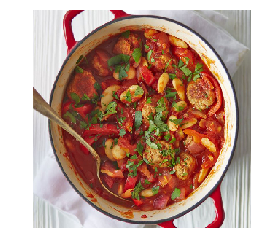

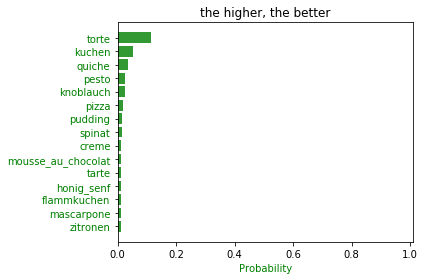

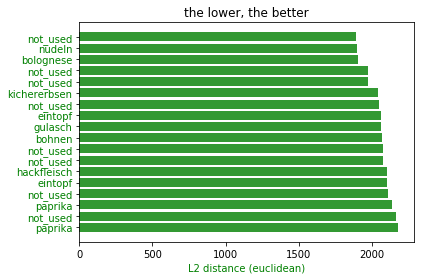

798941183540655-Andys fast vegetarische Minestrone
637561164557509-Nudeln mit Zucchini - Tomaten - Soße
1047581209586913-Tomatensalsa alla Mexiko
798941183540655-Andys fast vegetarische Minestrone
1628571270041078-Gemüseauflauf à la Anna
2081081336212283-Kichererbsen-Curry
1198301225722538-Thailändische Reissuppe mit Garnelen


Menge,Zutat
Menge,Zutat
Menge,Zutat
Menge,Zutat
Menge,Zutat
Menge,Zutat
Menge,Zutat


In [49]:
result_list = model_predict('uploads/18.jpg')
ids = [food_id[2] for food_id in result_list]
# For debugging purposes take online=False
# For production take online=True
food = food_list_html(result_list=result_list[:7], online=False)

#pprint(result_list)

chart = HTML(''.join(map(str, food)))
display(chart)